In [1]:
import qiskit
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

# Key operators

In [2]:
def init_source_op(qc, q, source):
    """Construct the source state from all 0's state"""
    for qbit, sbit in zip(q, source):
        if sbit:
            qc.x(qbit)
            
def a_op(qc, q, source, inv=False):
    """Construct all equal superposition from initial (source) state"""
    for qbit, sbit in zip(q, source):
        qc.rx((-1)**(inv+sbit)*np.pi/2, qbit)
    
def mcz_op(qc, controls, target):
    """Multi-controlled-Z operator"""
    return qc.mcu1(np.pi, controls, target)
    
def ss_op(qc, q):
    """Reflection about initial (source) state"""
    # multi-controlled-Z
    qc.mcu1(np.pi, q[:-1], q[-1])
    
def st_op(qc, q, target):
    """Reflection about target state (t)"""
    # flip qubits corresponding to a zero target bit
    for qbit, tbit in zip(q, target):
        if not tbit:
            qc.x(qbit)
    # multi-controlled-Z
    qc.mcu1(np.pi, q[:-1], q[-1])
    # flip qubits corresponding to a zero target bit
    for qbit, tbit in zip(q, target):
        if not tbit:
            qc.x(qbit)

def grover_op(qc, q, source, target):
    """Operator for one Grover iteration"""
    st_op(qc, q, target)
    a_op(qc, q, source, inv=False)
    ss_op(qc, q)
    a_op(qc, q, source, inv=True)

# Construct quantum circuit

In [3]:
# inputs
n = 5
source = [0, 0, 0, 0, 0]
target = [0, 1, 0, 1, 0]

# optimal iterations
niter = int(np.round(np.pi*np.sqrt(2**n)/4))
print("Optimal number of iterations = %s" % niter)

# quantum circuit
q = qiskit.QuantumRegister(n, name='q')
c = qiskit.ClassicalRegister(n, name='c')
qc = qiskit.QuantumCircuit(q, c, name='qc')

# initialize
# construct source
init_source_op(qc, q, source)
# construct equal superposition
a_op(qc, q, source)

# Grover iterations
for _ in range(niter):
    grover_op(qc, q, source, target)
    
# measurement
list(map(lambda x: qc.measure(*x), zip(q, c)))

print("------- operation counts (raw) -------")
for op, count in qc.count_ops().items():
    if op == 'measure':
        continue
    print("%s: %d" % (op, count))
    
print("------- operation counts (decomposed) -------")
for op, count in qc.decompose().count_ops().items():
    if op == 'measure':
        continue
    print("%s: %d" % (op, count))

# qc.draw()

Optimal number of iterations = 4
------- operation counts (raw) -------
rx: 45
x: 24
mcu1: 8
------- operation counts (decomposed) -------
cu1: 120
cx: 112
r: 45
u3: 24


# Qiskit simulation

{'01001': 1, '01000': 1, '01010': 4094}


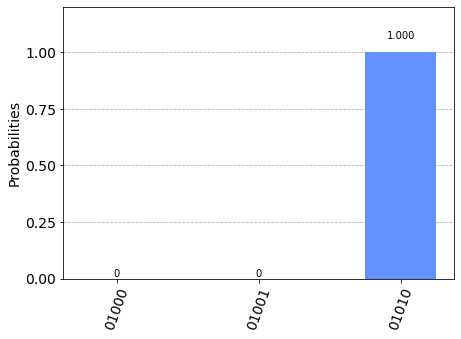

In [4]:
# qasm simulator
backend = qiskit.BasicAer.get_backend('qasm_simulator')
job = qiskit.execute(qc, backend, shots=4096)
results = job.result().get_counts()
print(results)
qiskit.visualization.plot_histogram(results)

In [5]:
# state vector simulator
backend = qiskit.BasicAer.get_backend('statevector_simulator')
qc.remove_final_measurements()
job = qiskit.execute(qc, backend)
job.result().get_statevector()

array([ 5.13584637e-03-1.53915659e-16j, -3.51534916e-17-5.13584637e-03j,
       -1.12012064e-16-5.13584637e-03j, -5.13584637e-03+7.68592990e-17j,
       -1.43224366e-16-5.13584637e-03j, -5.13584637e-03+9.32621257e-17j,
       -5.13584637e-03+4.01853993e-17j,  1.95676637e-17+5.13584637e-03j,
       -1.53173688e-16-5.13584637e-03j, -5.13584637e-03+2.10316187e-16j,
        9.99591074e-01+9.64017034e-16j,  7.91718452e-17+5.13584637e-03j,
       -5.13584637e-03+8.63820074e-17j,  5.58442365e-17+5.13584637e-03j,
       -8.74379556e-19+5.13584637e-03j,  5.13584637e-03-4.02021693e-17j,
       -7.59352019e-17-5.13584637e-03j, -5.13584637e-03+1.92622271e-18j,
       -5.13584637e-03-1.64028298e-18j,  3.67650886e-17+5.13584637e-03j,
       -5.13584637e-03+1.23055688e-16j,  1.08399478e-16+5.13584637e-03j,
        4.05004931e-18+5.13584637e-03j,  5.13584637e-03-3.22572001e-17j,
       -5.13584637e-03+9.09886416e-17j,  9.02246552e-17+5.13584637e-03j,
       -3.11999360e-17+5.13584637e-03j,  5.13584637

In [6]:
backend = qiskit.BasicAer.get_backend('unitary_simulator')
qc.remove_final_measurements()
job = qiskit.execute(qc, backend)
job.result().get_unitary()

array([[ 5.13584637e-03-1.53915659e-16j, -3.01124045e-16+1.50234296e-01j,
        -9.38858734e-17+2.03319095e-01j, ...,
        -2.03319095e-01-2.20031636e-16j, -1.50234296e-01-1.01330794e-16j,
        -1.59464702e-16+1.50234296e-01j],
       [-3.51534916e-17-5.13584637e-03j, -2.03319095e-01-2.74702566e-16j,
         2.03319095e-01+2.79210394e-16j, ...,
         1.56162385e-16-1.50234296e-01j, -2.38223755e-16+1.50234296e-01j,
        -2.03319095e-01-7.09335638e-17j],
       [-1.12012064e-16-5.13584637e-03j,  1.50234296e-01+2.20359841e-16j,
        -1.50234296e-01-1.43755015e-16j, ...,
        -1.25441820e-16+2.03319095e-01j,  9.71423689e-17-2.03319095e-01j,
        -2.03319095e-01-9.29155936e-17j],
       ...,
       [ 5.13584637e-03-4.39023634e-17j,  1.81760198e-16-2.03319095e-01j,
        -1.57836891e-16+2.03319095e-01j, ...,
        -2.03319095e-01+1.35299737e-16j,  2.03319095e-01-1.74957494e-16j,
         2.11395454e-16+1.50234296e-01j],
       [ 5.13584637e-03-2.23858253e-19j, -1.

# Analysis

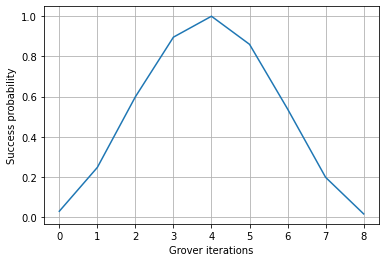

In [7]:
# success rate vs number of iterations

# inputs
n = 5
source = [0, 0, 0, 0, 0]
target = [0, 1, 0, 1, 0]

# simulation parameters
backend = qiskit.BasicAer.get_backend('qasm_simulator')
shots = 4096
niters = list(range(9))

# outputs
res = []

# iterate over number of Grover iterations
for r in niters:
    
    q = qiskit.QuantumRegister(n, name='q')
    c = qiskit.ClassicalRegister(n, name='c')
    qc = qiskit.QuantumCircuit(q, c, name='qc')
    
    # initialize
    # construct source
    init_source_op(qc, q, source)
    # construct equal superposition
    a_op(qc, q, source)
    
    # Grover iterations
    for _ in range(r):
        grover_op(qc, q, source, target)

    # measure
    list(map(lambda x: qc.measure(*x), zip(q, c)))

    job = qiskit.execute(qc, backend, shots=shots)
    counts = job.result().get_counts().get('01010', 0)
    res.append(counts)
    
# plot
plt.plot(niters, [c/shots for c in res])
plt.xlabel("Grover iterations")
plt.ylabel("Success probability")
plt.grid('on')